In [6]:
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [7]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [8]:
df_trans = pd.read_csv('kaggle_data/credit_card_transactions-ibm_v2.csv').sample(n=5000000, random_state=42)

In [9]:
df = df_trans

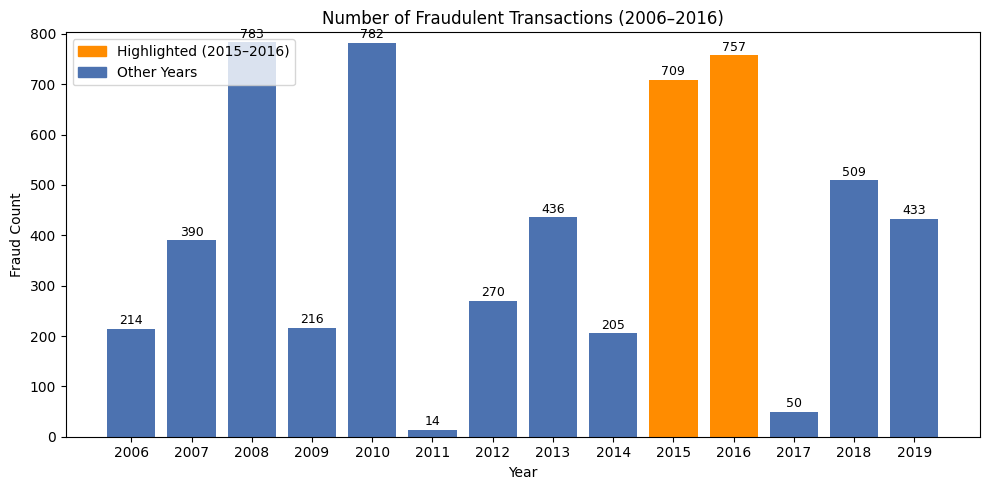

In [10]:
# EDA Fraud Label Transaction
fraud_trans = df_trans[df_trans['Is Fraud?']=='Yes']

year_counts = fraud_trans['Year'].value_counts().sort_index()  
year_counts = year_counts[year_counts.index >= 2006]
fraud_by_year = year_counts.to_dict()

years = sorted(fraud_by_year.keys())
counts = [fraud_by_year[y] for y in years]

colors = ['#FF8C00' if y in [2015, 2016] else '#4C72B0' for y in years]

plt.figure(figsize=(10, 5))
bars = plt.bar(years, counts, color=colors)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 3, str(count),
             ha='center', va='bottom', fontsize=9)

plt.title('Number of Fraudulent Transactions (2006–2016)')
plt.xlabel('Year')
plt.ylabel('Fraud Count')
plt.xticks(years)
plt.ylim(0, max(counts) + 20)

# Chú thích
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#FF8C00', label='Highlighted (2015–2016)'),
    plt.Rectangle((0,0),1,1, color='#4C72B0', label='Other Years')],
    loc='upper left')

plt.tight_layout()
plt.show()

In [11]:
df = df[df['Year'].isin([2015,2016])]
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,No
1775807,142,0,2016,8,20,06:28,$40.11,Chip Transaction,-1263263438141072419,Woodinville,WA,98077.0,5912,NaN,No
14643407,1201,0,2015,9,20,01:52,$69.70,Chip Transaction,-4259710328928763776,Montgomery,AL,36106.0,7349,NaN,No
20428972,1666,1,2016,8,9,10:51,$1.19,Chip Transaction,6666504894937430109,Spanish Fork,UT,84660.0,5499,NaN,No


# EDA Fraud Label Transactions

In [12]:
fraud_trans['Merchant City'].value_counts().head()

Merchant City
ONLINE            3838
Rome               959
Algiers            109
Port au Prince      80
Strasburg           60
Name: count, dtype: int64

In [13]:
df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'],axis=1)
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)
df["Merchant"] = df["Merchant Name"].astype(str) + "_" + df["Merchant City"].astype(str)

In [14]:
import pandas as pd

fraud_df = df[df['Is Fraud?'] == 1].copy()  # Giả sử 'Is Fraud?' = 1 là fraud

# 1. Top 5 user có nhiều fraud nhất
user_fraud = fraud_df['card_id'].value_counts().head(10)
user_total = df['card_id'].value_counts()[user_fraud.index]

user_stats = pd.DataFrame({
    'Total Transactions': user_total,
    'Fraud Transactions': user_fraud,
    'Fraud Rate': user_fraud / user_total
}).sort_values('Fraud Transactions', ascending=False)

# 2. Top 5 merchant có nhiều fraud nhất
merchant_fraud = fraud_df['Merchant'].value_counts().head(10)
merchant_total = df['Merchant'].value_counts()[merchant_fraud.index]

merchant_stats = pd.DataFrame({
    'Total Transactions': merchant_total,
    'Fraud Transactions': merchant_fraud,
    'Fraud Rate': merchant_fraud / merchant_total
}).sort_values('Fraud Transactions', ascending=False)

print("Top 10 Users with Most Fraud Transactions:")
display(user_stats)
print("\nTop 10 Merchants with Most Fraud Transactions:")
display(merchant_stats)

Top 10 Users with Most Fraud Transactions:


,Total Transactions,Fraud Transactions,Fraud Rate
card_id,,,
461_0,92,9,0.097826
220_0,108,9,0.083333
1735_1,171,8,0.046784
929_0,79,8,0.101266
1487_5,99,8,0.080808
1495_1,151,7,0.046358
1202_0,203,7,0.034483
1744_0,128,6,0.046875
453_0,311,6,0.019293



Top 10 Merchants with Most Fraud Transactions:


,Total Transactions,Fraud Transactions,Fraud Rate
Merchant,,,
-4282466774399734331_ONLINE,156,156,1.000000
1913477460590765860_ONLINE,106,106,1.000000
4872340518840476610_ONLINE,37,37,1.000000
-3220758452254689706_ONLINE,33,33,1.000000
-5904116920141006298_ONLINE,28,28,1.000000
-2042049018365856408_ONLINE,1072,22,0.020522
-521141999023077663_ONLINE,1071,21,0.019608
2122301195314255670_ONLINE,21,21,1.000000
7035602569409149834_ONLINE,2678,20,0.007468


# Training Process

## Preprocess and Feature Selection 

In [15]:
orig_df = df
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City' ,'MCC', 'Is Fraud?']
df = orig_df[columns_to_select]
df['isOnline'] = np.where(df['Merchant City'] == 'ONLINE', 1, 0)
df = df.drop(['Merchant City'],axis=1)

orig_df = orig_df.drop(["User","Card"],axis=1)

In [16]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=   0.8s


## Split Train-Test Data

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1613)
train_idx = X_train.index
test_idx = X_test.index

In [18]:
orig_df.rename(columns={"Merchant": "merchant_node", "card_id": "client_node", "Is Fraud?":"fraud_label"}, inplace=True)
columns_to_select = ['Year', 'Hour', 'Amount', 'Day of Week', 'Use Chip', 'merchant_node', 'MCC', 'client_node','fraud_label']

graph_df = orig_df[columns_to_select]

In [19]:
graph_df["Day of Week"]=LabelEncoder().fit_transform(graph_df["Day of Week"])
graph_df["Use Chip"]=LabelEncoder().fit_transform(graph_df["Use Chip"])

In [20]:
train_data = graph_df.loc[train_idx]
inductive_data = graph_df.loc[test_idx]

## Build Train Graph

In [21]:
from inductiveGRL.graphconstruction import GraphConstruction

transaction_node_data = train_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1)
client_node_data = pd.DataFrame([1]*len(train_data.client_node.unique())).set_index(train_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(train_data.merchant_node.unique())).set_index(train_data.merchant_node.unique())

nodes = {"client":train_data.client_node, "merchant":train_data.merchant_node, "transaction":train_data.index}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 625625, Edges: 1118304

 Node types:
  transaction: [559152]
    Features: float32 vector, length 6
    Edge types: transaction-default->client, transaction-default->merchant
  merchant: [62392]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction
  client: [4081]
    Features: float32 vector, length 1
    Edge types: client-default->transaction

 Edge types:
    merchant-default->transaction: [559152]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [559152]
        Weights: all 1 (default)
        Features: none


In [22]:
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

embedding_size = 32
add_additional_data = True
#GraphSAGE parameters
num_samples = [2,64]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['fraud_label'], batch_size=5, epochs=8)

Epoch 1/8
89465/89465 [==============================] - 266s 3ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 2/8
89465/89465 [==============================] - 241s 3ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 3/8
89465/89465 [==============================] - 254s 3ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 4/8
89465/89465 [==============================] - 246s 3ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 5/8
89465/89465 [==============================] - 259s 3ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 6/8
89465/89465 [==============================] - 284s 3ms/step - loss: 0.0131 - val_loss: 0.0136
Epoch 7/8
89465/89465 [==============================] - 269s 3ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 8/8
111831/111831 [==============================] - 251s 2ms/step


In [24]:
import torch

# Save the trained model's state_dict
torch.save(trained_hinsage_model, 'hinsage_model.pt')

In [25]:
np.save('train_emb.npy', train_emb)

## Build Test Graph

In [26]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

transaction_node_data = inductive_graph_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1)
client_node_data = pd.DataFrame([1]*len(inductive_graph_data.client_node.unique())).set_index(inductive_graph_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(inductive_graph_data.merchant_node.unique())).set_index(inductive_graph_data.merchant_node.unique())

nodes = {"client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node, "transaction":inductive_graph_data.index}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}
 
graph = GraphConstruction(nodes, edges, features)
S_combined = graph.get_stellargraph()
print(S_combined.info())

StellarGraph: Undirected multigraph
 Nodes: 770895, Edges: 1397882

 Node types:
  transaction: [698941]
    Features: float32 vector, length 6
    Edge types: transaction-default->client, transaction-default->merchant
  merchant: [67873]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction
  client: [4081]
    Features: float32 vector, length 1
    Edge types: client-default->transaction

 Edge types:
    merchant-default->transaction: [698941]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [698941]
        Weights: all 1 (default)
        Features: none


In [ ]:
from stellargraph.mapper import HinSAGENodeGenerator

test_generator = HinSAGENodeGenerator(
    S_combined,
    batch_size=5,  
    num_samples=[2, 64],  
    head_node_type="transaction"
).flow(inductive_data.index)  

try:
    test_predictions = trained_hinsage_model.predict(test_generator)
except ValueError:
    test_predictions = []
    for batch in test_generator:
        if isinstance(batch, (list, tuple)):
            batch = batch[0] 
        preds = trained_hinsage_model.predict(batch)
        test_predictions.extend(preds.squeeze())
    test_predictions = np.array(test_predictions)

inductive_emb = pd.DataFrame(np.vstack(test_predictions), index=inductive_data.index)


# Test and Analyze the result

In [ ]:
# Fusion model 
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
train_emb_pca = pd.DataFrame(pca.fit_transform(train_emb), index=train_emb.index)
test_emb_pca = pd.DataFrame(pca.transform(inductive_emb), index=inductive_emb.index)

concat_train_emb= pd.merge(train_emb_pca, X_train, left_index=True, right_index=True)
concat_inductive_emb = pd.merge(test_emb_pca, X_test, left_index=True, right_index=True)
concat_train_emb.columns = concat_train_emb.columns.astype(str)
concat_inductive_emb.columns = concat_inductive_emb.columns.astype(str)

xgb_classifier = XGBClassifier(n_estimators=100, 
                            use_label_encoder=False,  
                            eval_metric='logloss',  
                            random_state=42)

xgb_classifier.fit(concat_train_emb, y_train)

y_pred_xgb_hinsage = xgb_classifier.predict(concat_inductive_emb)
cm_fusion = confusion_matrix(y_test, y_pred_xgb_hinsage)
print(cm_fusion)

[[139486      8]
 [    93    202]]


In [29]:
# Tabular only model
xgb_classifier = XGBClassifier(n_estimators=100, 
                            use_label_encoder=False,  
                            eval_metric='logloss',   
                            random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred_xgb = xgb_classifier.predict(X_test)
cm_tabular = confusion_matrix(y_test, y_pred_xgb)
print(cm_tabular)

[[139481     13]
 [    97    198]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def compute_metrics(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'F1': f1_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred)
    }

metrics_xgb = compute_metrics(y_test, y_pred_xgb, 'XGB')
metrics_xgb_hinsage = compute_metrics(y_test, y_pred_xgb_hinsage, 'XGB + HinSAGE')

# Combine into a list
results = [metrics_xgb, metrics_xgb_hinsage]

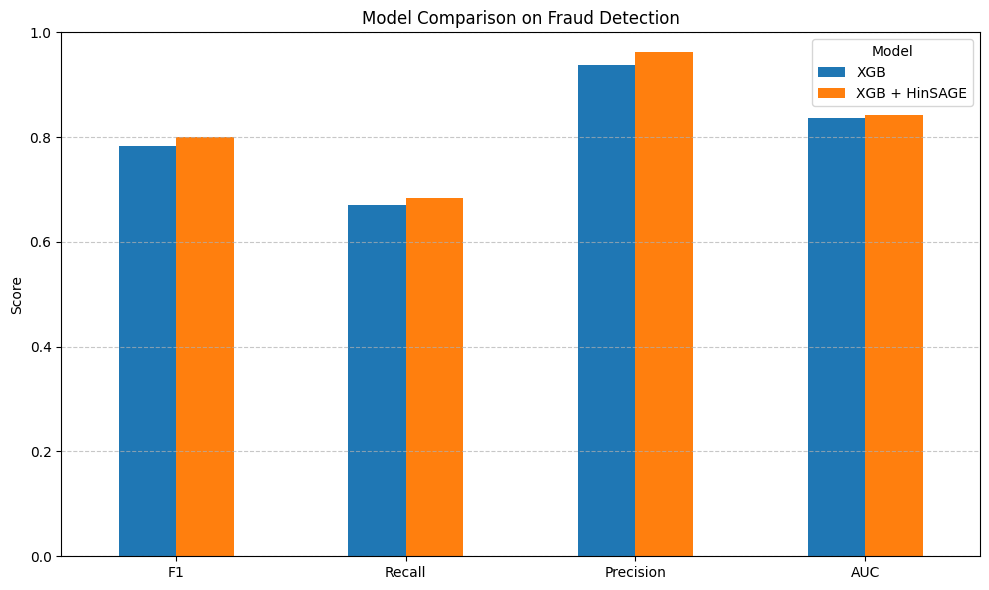

In [37]:
df_metrics = pd.DataFrame(results).set_index('Model')
df_metrics = df_metrics.T  # transpose for easier bar plotting

# Plotting
ax = df_metrics.plot(kind='bar', figsize=(10,6), rot=0)
plt.title('Model Comparison on Fraud Detection')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [46]:
# Check fraud label fusion model catch only
df_compare = pd.DataFrame({
    'y_true': y_test,
    'pred_fusion': y_pred_xgb_hinsage,
    'pred_tabular': y_pred_xgb
})

df_fusion_catch_only = df_compare[
    (df_compare['y_true'] == 1) &
    (df_compare['pred_fusion'] == 1) &
    (df_compare['pred_tabular'] == 0)
]

detail_fusion_catch_only_df = orig_df.loc[df_fusion_catch_only.index]

In [ ]:
target_merchants = detail_fusion_catch_only_df['merchant_node']

filtered_df = orig_df[orig_df['merchant_node'].isin(target_merchants)].copy()

result = (
    filtered_df
    .groupby('merchant_node')
    .agg(
        total_transactions=('fraud_label', 'size'),         
        fraud_transactions=('fraud_label', 'sum'),           
        fraud_rate=('fraud_label', lambda x: x.mean() * 100)
    )
    .reset_index()
    .sort_values(by='fraud_rate', ascending=False)
)

In [55]:
display(result)

,merchant_node,total_transactions,fraud_transactions,fraud_rate
0,-1396821880537214279_ONLINE,5,5,100.000000
1,-3693650930986299431_ONLINE,6,6,100.000000
2,3889178423469304880_Fairfield,1,1,100.000000
4,4872340518840476610_ONLINE,37,37,100.000000
5,7479593622964634169_ONLINE,10,10,100.000000
6,8127612394886242674_Oakland,1,1,100.000000
3,4796006601552743675_ONLINE,58,7,12.068966
